# FIFA Players Classification

This notebook contains the code to train models for the FIFA Classification problem based on their attributes

## Step 1: Import libraries

Libraries we will be using:
- **tensorflow** and **keras**: APIs for neural network model construction and training
- **numpy**: Numerical python library.
- **pandas**: Will be used to work with dataframes from .csv files.
- **sklearn**: Will be used to modify the labels of the data and do some statistical modifications.
- **matplotlib**: Will be used to plot graphics.
- **time**: To measure training time.
- **datetime**: To get the datetime a new model is created and use that to create its name

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

## Step 2: Load data

We first define the path to our data

In [2]:
DATA_FOLDER = "../Data"

ATT_FILE = f"{DATA_FOLDER}/FootballPlayerPreparedCleanAttributes.csv"
IMPUTED_ATT_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/FootballPlayerOneHotEncodedClasses.csv"
IMPUTED_ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

Specify training options:
- **IMPUTED_DATA**: We will use file with data imputed
- **TRAIN_RATE**: The amount of instances to use during training, it will also determine the dev and test instances number indirectly

In [3]:
IMPUTED_DATA = False    # Use imputed dataset
TRAIN_RATE = 0.8        # The division of the data for training, validation and test

Because our data has more than 10000, we will be using 80-10-10 split in our dataset:
- **80%** for training
- **10%** for validation/dev test
- **10%** for final test

In [4]:
if IMPUTED_DATA:
    attributes = pd.read_csv(ATT_IMPUTED_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_IMPUTED_FILE)
else:
    attributes = pd.read_csv(ATT_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_FILE)

n_total_instances = attributes.shape[0]
n_train_instances = int(n_total_instances * TRAIN_RATE)
n_dev_instances = int((n_total_instances - n_train_instances)/2)

instances_train = attributes.values[:n_train_instances]
labels_train = labels.values[:n_train_instances]

instances_dev = attributes.values[n_train_instances: n_train_instances + n_dev_instances]
labels_dev = labels.values[n_train_instances: n_train_instances + n_dev_instances]

print("instances_train:", instances_train.shape)
print("labels_train:", labels_train.shape)
print("instances_dev:", instances_dev.shape)
print("labels_dev:",labels_dev.shape)

instances_train: (12897, 17)
labels_train: (12897, 4)
instances_dev: (1612, 17)
labels_dev: (1612, 4)


## Step 3: Initialize variables
- **INPUT_SIZE**: The size of the training instances
- **OUTPUT_SIZE**: The number of possible classes
- **NUM_TRAINING_EXAMPLES**: The number of possible classes
- **NUM_DEV_EXAMPLES**: The number of validation/dev test instances

In [5]:
INPUT_SIZE = instances_train.shape[1]
OUTPUT_SIZE = labels_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(instances_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(instances_dev.shape[0]/1))

## Step 4: Set hyperparameters

- **LEARNING_RATE** $\alpha$: The step size in the learning process
- **BATCH_SIZE**: The size of each batch
- **N_HIDDEN**: Number of neurons in the hidden.

The learning process stops when it reaches 20,000 learning iterations. An iteration comprises presenting the network *batch_size* learning examples and then adjusting the weights (parameters).

In [6]:
N_EPOCHS = 400
LEARNING_RATE = 0.001
BATCH_SIZE = 256
ACTIVATION = "relu"
N_HIDDEN = [2048, 1024, 512, 256, 128, 64, 32]
REGULARIZER = keras.regularizers.l1(0.0001)
INITIALIZER = keras.initializers.he_normal(seed=None)
LOSS = tf.keras.losses.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
METRICS = ["categorical_accuracy"]

## Step 5: Build the model

In [7]:
def architecture1():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,), batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons, activation=ACTIVATION))
    model.add(keras.layers.Dense(OUTPUT_SIZE, activation="softmax"))
    
    model_name = "D512"
    return model, model_name


def architecture2():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     activation=ACTIVATION,
                                     kernel_regularizer=REGULARIZER
                                    ))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE, 
                                 activation="softmax"))
    
    model_name = "D128_D64_D32"
    return model, model_name

def architecture3():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    model_name = "D128_BN_D64_BN_D32_BN"
    return model, model_name

def architecture4():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeNormal(seed=None),
                                     use_bias=False
                                     ))
    
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    model_name = "D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_BN_D32_BN"
    return model, model_name


def compile_model(model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=METRICS)

In [8]:
my_model, model_name = architecture4()

In [9]:
compile_model(my_model)

## Step 6: Train the model

In [10]:
start_time = time.perf_counter()
history = my_model.fit(instances_train,
                       labels_train,
                       batch_size=BATCH_SIZE,
                       epochs=N_EPOCHS,
                       verbose=1,
                       validation_data=(instances_dev, labels_dev))
end_time = time.perf_counter()

Epoch 1/400
51/51 [==============================] - 5s 24ms/step - loss: 9.3982 - categorical_accuracy: 0.7376 - val_loss: 11.0555 - val_categorical_accuracy: 0.4541
Epoch 2/400
51/51 [==============================] - 1s 18ms/step - loss: 7.4742 - categorical_accuracy: 0.7869 - val_loss: 6.7500 - val_categorical_accuracy: 0.6898
Epoch 3/400
51/51 [==============================] - 1s 18ms/step - loss: 5.6606 - categorical_accuracy: 0.7972 - val_loss: 5.0088 - val_categorical_accuracy: 0.7320
Epoch 4/400
51/51 [==============================] - 1s 18ms/step - loss: 4.3462 - categorical_accuracy: 0.7880 - val_loss: 4.0855 - val_categorical_accuracy: 0.6600
Epoch 5/400
51/51 [==============================] - 1s 18ms/step - loss: 3.4810 - categorical_accuracy: 0.7854 - val_loss: 3.6471 - val_categorical_accuracy: 0.5937
Epoch 6/400
51/51 [==============================] - 1s 19ms/step - loss: 2.9318 - categorical_accuracy: 0.7816 - val_loss: 3.2106 - val_categorical_accuracy: 0.5751
Epo

51/51 [==============================] - 1s 23ms/step - loss: 0.6983 - categorical_accuracy: 0.8371 - val_loss: 0.7655 - val_categorical_accuracy: 0.7940
Epoch 51/400
51/51 [==============================] - 1s 22ms/step - loss: 0.7126 - categorical_accuracy: 0.8262 - val_loss: 0.8978 - val_categorical_accuracy: 0.7401
Epoch 52/400
51/51 [==============================] - 1s 22ms/step - loss: 0.7011 - categorical_accuracy: 0.8352 - val_loss: 0.8320 - val_categorical_accuracy: 0.7649
Epoch 53/400
51/51 [==============================] - 1s 22ms/step - loss: 0.6903 - categorical_accuracy: 0.8365 - val_loss: 0.8462 - val_categorical_accuracy: 0.7717
Epoch 54/400
51/51 [==============================] - 1s 22ms/step - loss: 0.6887 - categorical_accuracy: 0.8357 - val_loss: 0.7616 - val_categorical_accuracy: 0.8033
Epoch 55/400
51/51 [==============================] - 1s 22ms/step - loss: 0.6762 - categorical_accuracy: 0.8334 - val_loss: 0.8463 - val_categorical_accuracy: 0.7773
Epoch 56/40

51/51 [==============================] - 1s 22ms/step - loss: 0.4372 - categorical_accuracy: 0.8853 - val_loss: 0.8070 - val_categorical_accuracy: 0.7643
Epoch 100/400
51/51 [==============================] - 1s 22ms/step - loss: 0.4409 - categorical_accuracy: 0.8809 - val_loss: 0.7946 - val_categorical_accuracy: 0.7618
Epoch 101/400
51/51 [==============================] - 1s 22ms/step - loss: 0.4484 - categorical_accuracy: 0.8768 - val_loss: 0.7663 - val_categorical_accuracy: 0.7699
Epoch 102/400
51/51 [==============================] - 1s 22ms/step - loss: 0.4414 - categorical_accuracy: 0.8829 - val_loss: 0.7656 - val_categorical_accuracy: 0.7612
Epoch 103/400
51/51 [==============================] - 1s 22ms/step - loss: 0.4556 - categorical_accuracy: 0.8765 - val_loss: 0.7920 - val_categorical_accuracy: 0.7568
Epoch 104/400
51/51 [==============================] - 1s 22ms/step - loss: 0.4214 - categorical_accuracy: 0.8937 - val_loss: 0.7513 - val_categorical_accuracy: 0.7785
Epoch 

Epoch 148/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3886 - categorical_accuracy: 0.9071 - val_loss: 0.8524 - val_categorical_accuracy: 0.7643
Epoch 149/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3620 - categorical_accuracy: 0.9166 - val_loss: 0.9176 - val_categorical_accuracy: 0.7556
Epoch 150/400
51/51 [==============================] - 1s 23ms/step - loss: 0.3797 - categorical_accuracy: 0.9077 - val_loss: 0.8818 - val_categorical_accuracy: 0.7692
Epoch 151/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3801 - categorical_accuracy: 0.9049 - val_loss: 0.8917 - val_categorical_accuracy: 0.7618
Epoch 152/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3577 - categorical_accuracy: 0.9163 - val_loss: 0.9328 - val_categorical_accuracy: 0.7655
Epoch 153/400
51/51 [==============================] - 1s 23ms/step - loss: 0.3697 - categorical_accuracy: 0.9121 - val_loss: 0.9542 - val_categorical_accuracy:

Epoch 197/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3186 - categorical_accuracy: 0.9353 - val_loss: 1.0205 - val_categorical_accuracy: 0.7531
Epoch 198/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3260 - categorical_accuracy: 0.9301 - val_loss: 1.0032 - val_categorical_accuracy: 0.7612
Epoch 199/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3360 - categorical_accuracy: 0.9260 - val_loss: 1.0143 - val_categorical_accuracy: 0.7699
Epoch 200/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3230 - categorical_accuracy: 0.9332 - val_loss: 1.0651 - val_categorical_accuracy: 0.7550
Epoch 201/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3196 - categorical_accuracy: 0.9340 - val_loss: 1.0851 - val_categorical_accuracy: 0.7450
Epoch 202/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3290 - categorical_accuracy: 0.9319 - val_loss: 1.0873 - val_categorical_accuracy:

Epoch 246/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3204 - categorical_accuracy: 0.9332 - val_loss: 1.1362 - val_categorical_accuracy: 0.7543
Epoch 247/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3051 - categorical_accuracy: 0.9421 - val_loss: 1.0931 - val_categorical_accuracy: 0.7500
Epoch 248/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3188 - categorical_accuracy: 0.9363 - val_loss: 1.0535 - val_categorical_accuracy: 0.7457
Epoch 249/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3180 - categorical_accuracy: 0.9355 - val_loss: 1.0931 - val_categorical_accuracy: 0.7587
Epoch 250/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3289 - categorical_accuracy: 0.9331 - val_loss: 1.0886 - val_categorical_accuracy: 0.7550
Epoch 251/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3282 - categorical_accuracy: 0.9332 - val_loss: 1.1019 - val_categorical_accuracy:

Epoch 295/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2984 - categorical_accuracy: 0.9477 - val_loss: 1.1222 - val_categorical_accuracy: 0.7481
Epoch 296/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2656 - categorical_accuracy: 0.9598 - val_loss: 1.2552 - val_categorical_accuracy: 0.7376
Epoch 297/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2912 - categorical_accuracy: 0.9498 - val_loss: 1.2040 - val_categorical_accuracy: 0.7475
Epoch 298/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2989 - categorical_accuracy: 0.9442 - val_loss: 1.1807 - val_categorical_accuracy: 0.7481
Epoch 299/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2776 - categorical_accuracy: 0.9560 - val_loss: 1.1880 - val_categorical_accuracy: 0.7463
Epoch 300/400
51/51 [==============================] - 1s 22ms/step - loss: 0.3046 - categorical_accuracy: 0.9432 - val_loss: 1.1902 - val_categorical_accuracy:

Epoch 344/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2649 - categorical_accuracy: 0.9607 - val_loss: 1.1626 - val_categorical_accuracy: 0.7643
Epoch 345/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2635 - categorical_accuracy: 0.9605 - val_loss: 1.2323 - val_categorical_accuracy: 0.7444
Epoch 346/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2878 - categorical_accuracy: 0.9546 - val_loss: 1.2034 - val_categorical_accuracy: 0.7618
Epoch 347/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2593 - categorical_accuracy: 0.9638 - val_loss: 1.2407 - val_categorical_accuracy: 0.7512
Epoch 348/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2942 - categorical_accuracy: 0.9538 - val_loss: 1.3107 - val_categorical_accuracy: 0.7401
Epoch 349/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2816 - categorical_accuracy: 0.9551 - val_loss: 1.1975 - val_categorical_accuracy:

Epoch 393/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2588 - categorical_accuracy: 0.9650 - val_loss: 1.2510 - val_categorical_accuracy: 0.7525
Epoch 394/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2751 - categorical_accuracy: 0.9582 - val_loss: 1.5195 - val_categorical_accuracy: 0.7215
Epoch 395/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2911 - categorical_accuracy: 0.9508 - val_loss: 1.1916 - val_categorical_accuracy: 0.7469
Epoch 396/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2874 - categorical_accuracy: 0.9523 - val_loss: 1.2566 - val_categorical_accuracy: 0.7494
Epoch 397/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2564 - categorical_accuracy: 0.9669 - val_loss: 1.2368 - val_categorical_accuracy: 0.7407
Epoch 398/400
51/51 [==============================] - 1s 22ms/step - loss: 0.2393 - categorical_accuracy: 0.9726 - val_loss: 1.2555 - val_categorical_accuracy:

## Step 7: Analyze results

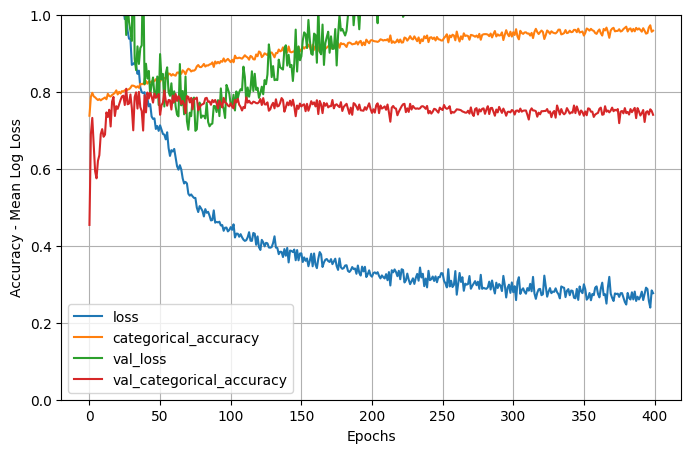

In [11]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
training_accuracy = round(results.categorical_accuracy.values[-1:][0]*100, 2)
val_accuracy = round(results.val_categorical_accuracy.values[-1:][0]*100, 2)
training_error = round((1 - results.categorical_accuracy.values[-1:][0])*100, 2)
test_error = round((1 - results.val_categorical_accuracy.values[-1:][0])*100, 2)
human_error = 5
bias = round(training_error - human_error, 2)
variance = round(test_error - training_error, 2)
training_time = round(end_time - start_time)
print("Training accuracy: ", training_accuracy, "%")
print("Validationa accuracy", val_accuracy, "%")
print("Error (training):", training_error, "%")
print("Error (test):", test_error, "%")
print("Bias:", bias)
print("Variance:", variance)
print("Time: ", training_time, "seconds")

Training accuracy:  95.86 %
Validationa accuracy 74.01 %
Error (training): 4.14 %
Error (test): 25.99 %
Bias: -0.86
Variance: 21.85
Time:  455 seconds


In [13]:
def draw_confusion_matrix(cm, categories, normalize=True):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3*pow(len(categories), 0.5), 2*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(12-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)


51/51 [==============================] - 0s 4ms/step


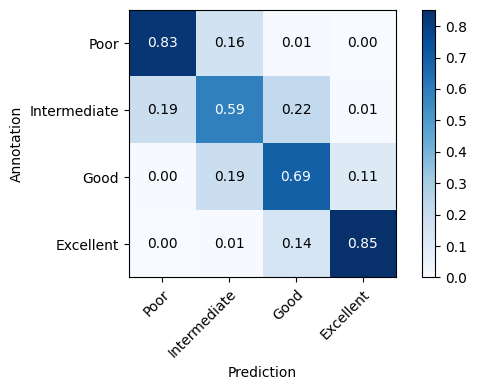

In [14]:
labels_pred = my_model.predict(instances_dev)
cm = confusion_matrix(np.argmax(labels_dev, axis=1), np.argmax(labels_pred, axis=1))
draw_confusion_matrix(cm, ["Poor", "Intermediate", "Good", "Excellent"])

## Step 8: Save results

In [15]:
RESULTS_FOLDER = "../Results"
RESULTS_FILE = f"{RESULTS_FOLDER}/models_performance.csv"

In [16]:
results_df = pd.read_csv(RESULTS_FILE, index_col = 0)

In [17]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'batch_size',
    'activation',
    'loss',
    'optimizer',
    'regularization',
    'initializer',
    'train_accuracy',
    'validation_accuracy',
    'bias',
    'variance',
    'training_time'
]

new_result = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    BATCH_SIZE,
    ACTIVATION,
    "categorical_crossentropy",
    "ADAM b109 b20999",
    "l1 0.0001",
    "he_normal",
    training_accuracy,
    val_accuracy,
    bias,
    variance,
    training_time]]

new_result_df = pd.DataFrame(new_result, columns=COLUMNS)
concatenation = pd.concat([results_df, new_result_df], ignore_index=True)
concatenation.to_csv(RESULTS_FILE)


In [18]:
# last_five = results_df.tail(5)
last_five = concatenation.tail(5)
print(last_five)
print("\n---Metrics---")
print(last_five[["train_accuracy", "validation_accuracy", "bias", "variance", "training_time"]].describe())

                                           model_name  epochs  learning_rate  \
79  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   
80  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   
81  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   
82  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   
83  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   

    batch_size activation                      loss         optimizer  \
79         256       relu  categorical_crossentropy  ADAM b109 b20999   
80         256       relu  categorical_crossentropy  ADAM b109 b20999   
81         256       relu  categorical_crossentropy  ADAM b109 b20999   
82         256       relu  categorical_crossentropy  ADAM b109 b20999   
83         256       relu  categorical_crossentropy  ADAM b109 b20999   

   regularization  train_accuracy  validation_accuracy   bias  variance  \
79   

In [19]:
MODELS_FOLDER = "../Models"
save_name = f"{MODELS_FOLDER}/{model_name}-5.h5"
my_model.save(save_name)